In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']


# Testing CC_AMA code

In [ ]:
os.chdir(libDir)
%run test_minimize.py
#os.chdir(specDataDir)

# Testing the Schur decomposition thingy
## $ Z = BH^* + HB^*$

In [194]:
# The decomposition should work for any Hermitian matrix,
Z = np.random.randn(21,21) + 1.j*np.random.randn(21,21)
Z = Z + Z.conj().T

B,H,S = ops.decomposeZ(Z)
print("Error in the decomposition for some random Hermitian matrix is,",
np.linalg.norm(
    Z - 
    (B @ H.conj().T + H @ B.conj().T),
    ord=2) )

Error in the decomposition for some random Hermitian matrix is, 5.817324301e-14


# Run phys2spec() for ReTau=186

In [ ]:
tArr = np.arange(100000,150050,50)
for t in tArr:
    miscUtil.phys2spec(t)

# Stat completition for turbulent channel flow

In [37]:
# Load turbulent mean for Re=590 from DNS data
#os.chdir(covDataDir)
#U0 = np.load(specDataDir+'uMeanN384.npy')
#U = np.zeros(U0.size+2)  # Add wall-nodes
#U[1:-1] = U0


# Interpolate to a grid with N=64 (internal nodes)
#N = 64
#Uc = pseudo.chebcoeffs(U)
#Uc = Uc[:N+2]
#U = pseudo.chebcoll_vec(Uc)
#U = U[1:-1] # Lose the wall-nodes



# Initialize statComp instance 
a = 2.5; b = 20./3.; N = 62; Re = 186.
statInst = ops.statComp(a=a, b=b, N=N, Re=Re)
# Re-assign attributes U, dU, d2U to reflect turbulent field
#statInst.U = U
#statInst.dU = statInst.D1 @ U
#statInst.d2U = statInst.D2 @ U




Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


In [ ]:
#X0= X
#Z0 = -(dynMat @ X0 + X0 @ dynMat.conj().T)
outStats = statInst.completeStats(iterMax=100,tolPrimal=1.0e-03,tolDual=1.0e-03,rankPar=10.,savePath='../')

In [36]:
outStats.keys(), statInst.a, statInst.b

(dict_keys(['steps', 'Y2', 'Y1', 'X', 'funPrimalArr', 'funDualArr', 'Z', 'dualGapArr', 'flag']),
 0.6666666666666666,
 6.666666666666667)

In [25]:
#Phi = outMat @ outStats['X']  @ outMat.conj().T
Phi = outMat @ cov_state  @ outMat.conj().T
N = statInst.N
w = statInst.w
WsqrtInv = np.diag(np.sqrt(np.concatenate((w,w,w))))
Phi_unweighted = WsqrtInv @ Phi @ WsqrtInv
cov_uu = Phi_unweighted[:N,:N]


In [ ]:
with h5py.File('../outStatsR186N62a00b06.hdf5','r') as inFile:
    pass

y = statInst.y
plt.contourf(y, y,np.abs(cov_uu[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()


# Matching eigenvalues of AX + XA*

In [99]:
a = 2.5; b = 20./3.; N = 62; Re = 186.
statInst = ops.statComp(a=a, b=b, N=N, Re=Re)

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


a, b, Re: 2.5 6.666666666666667 186.0
a, b, Re: 2.5 6.666666666666667 186.0
X-X.H: 7.58598032906e-19
[-0.01023628 -0.00612807 -0.00268982 -0.00178596 -0.00125487] [ 0.00112386  0.00182806  0.00335677  0.0073169   0.0090811 ]


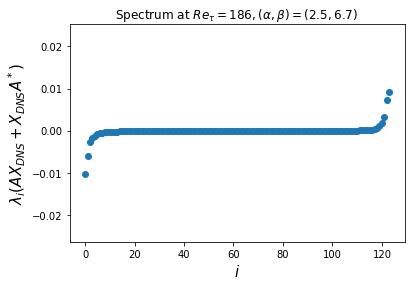

In [124]:
figureFolder='figures/'
A, C, B = statInst.makeSystem()
Aadj, Cadj, Badj = statInst.makeAdjSystem()
a0 = 0.25; b0 = 2./3.

Phi = statInst.covMat/a0/b0
Phi = 0.5*(Phi + Phi.conj().T)
X = B @ Phi @ B.conj().T
print("X-X.H:", np.linalg.norm((X - X.conj().T).flatten()))

evals,evecs = np.linalg.eig(A @ X + X @ Aadj )
evals = evals.real
evals = np.sort(evals)
print(evals[:5], evals[-5:])
#evals = evals[4:-4]
plt.scatter(np.arange(evals.size),np.real(evals))
plt.xlabel("$i$",fontsize=15); plt.ylabel("$\lambda_i(AX_{DNS} + X_{DNS}A^*)$",fontsize=15)
plt.title("Spectrum at $Re_{\\tau}=186, (\\alpha,\\beta) = (2.5,6.7)$ ")
#plt.ylim([-0.015,0.005])
plt.savefig(figureFolder+'spectrum.pdf',format='pdf')
plt.show()

array([ 0.11285152,  0.19399631,  0.24795435,  0.02357624,  0.10440523,
        0.26959656,  0.41470865,  0.69431979,  0.72204984,  0.81876371,
        0.80276107,  0.86441545,  0.87030961,  0.87907155,  0.92228337,
        0.9401819 ,  0.92914385,  0.93122482,  0.9515191 ,  0.94439813,
        0.95843334,  0.95610136,  0.95594594,  0.96355392,  0.97487274,
        0.97355528,  0.97604876,  0.97564922,  0.98031156,  0.98587451,
        0.99039507,  0.98974669,  0.99113285,  0.99182691,  0.99299565,
        0.99303558,  0.99165317,  0.99540189,  0.99670833,  0.99839876,
        0.9982451 ,  0.99913102,  1.00000814,  1.00018693,  1.00137889,
        1.00228023,  1.00818568,  1.01256848,  1.02028955,  1.02825255,
        1.03995437,  1.05287214,  1.05952668,  1.10011885,  1.14042547,
        1.19053371,  1.25036709,  1.34716218,  1.39336876,  1.54410316,
        1.68639699,  1.95687447])

In [44]:
dynMat, outMat, outMatInv = statInst.makeSystem()
a0 = 0.25; b0 = 2./3.
cov_vel = 4.*statInst.covMat

# Make covariances symmetric about centerline
for ind0 in range(3):
    for ind1 in range(3):
        tmpArr = cov_vel[ind0*N:ind0*N+N, ind1*N:ind1*N+N]  
        #cov_vel[ind0*N:ind0*N+N, ind1*N:ind1*N+N] = 0.5 * (tmpArr + tmpArr[::-1,::-1])
cov_vel_tmp = cov_vel.copy()        


# Compute covariance of state, X, from covariance of velocity, Phi
# Phi = W1/2 v  (W1/2 v)* = C psi  (C psi)* = C X C*
cov_state = outMatInv @ cov_vel @ outMatInv.conj().T

if False:
    C_phi = statInst.velVor2primitivesMat(a=statInst.a, b=statInst.b)
    W = np.diag( np.concatenate(( statInst.w, statInst.w, statInst.w )) )
    Q = C_phi.conj().T @ W @ C_phi
    Qsqrt = sqrtm(Q)
    B = statInst.primitives2velVorMat(a=statInst.a, b=statInst.b)

    # Need this matrix to convert covariance of weighted velocities to 
    #    covariance of unweighted velocities
    WsqrtInv = np.diag( np.sqrt(2.* (1./np.concatenate(( statInst.w, statInst.w, statInst.w ))) ) )
    # The factor 2 shows up because I changed the definition of 'w' since I computed 
    #    the covariances of weighted velocities
    cov_vel = WsqrtInv @ cov_vel @ WsqrtInv

    if False:
        cov_vel = statInst.structMat * cov_vel

    cov_state = Qsqrt @ B @ cov_vel @ B.conj().T  @ Qsqrt.conj().T


a, b, Re: 2.5 6.666666666666667 186.0


In [45]:
cov_vel_new = outMat @ cov_state @ outMat.conj().T
np.linalg.norm( (cov_vel_new - cov_vel).flatten())


4.7917421691850325e-05

[-0.00706376 -0.00543383 -0.00190116 -0.00146003 -0.00102909] [ 0.00095781  0.0014689   0.0027523   0.00860049  0.00946789]


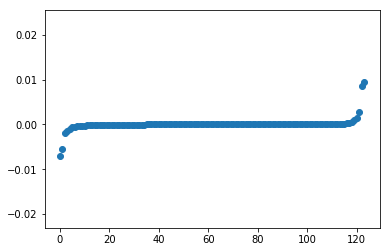

In [46]:
A = dynMat; X = cov_state
evals,evecs = np.linalg.eig(A @ X + X @ A.conj().T )
evals = evals.real
evals = np.sort(evals)
print(evals[:5], evals[-5:])
#evals = evals[4:-4]
plt.scatter(np.arange(evals.size),np.real(evals))
#plt.ylim([-0.015,0.005])
#plt.savefig(figureFolder+'spectrum.pdf',format='pdf')
plt.show()

In [125]:
from scipy.linalg import solve_lyapunov
Z0 = -(A @ X + X @ Aadj)
B,H,S = ops.decomposeZ(Z0)
np.linalg.matrix_rank(B), B.shape[0]

(79, 124)

In [126]:
H.shape

(124, 79)

In [127]:
C = outMat
Cf = ( H.conj().T - 0.5 * B.conj().T) @ np.linalg.inv(X)
Af = A + B @ Cf
omegaArr = np.arange(0., 101., 5.)
psdArr = np.zeros(omegaArr.size)
ampArr = psdArr.copy()
I = np.identity(Af.shape[0])

for ind in range(omegaArr.size):
    omega = omegaArr[ind]
    T_vw = -C @ np.linalg.pinv(1.j*omega*I + Af) @ B
    svalMax = np.linalg.norm(T_vw, ord=2)
    traceTT = np.trace( T_vw @ T_vw.conj().T )
    psdArr[ind] = traceTT
    ampArr[ind] = svalMax**2

/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


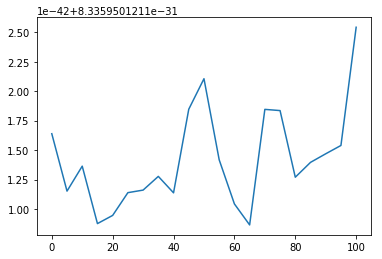

In [128]:
plt.plot(omegaArr, np.abs(psdArr))
plt.show()

In [129]:
omega=40.
T_vw = -C @ np.linalg.pinv(1.j*omega*I + Af) @ B
U,S,V = np.linalg.svd(T_vw)
noise = np.random.randn(T_vw.shape[1])
velVec = T_vw @ noise

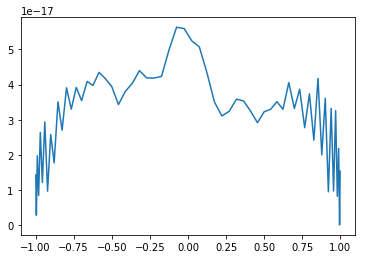

In [130]:
N = statInst.N
plt.plot(statInst.y, np.abs(velVec[N:2*N]))
plt.show()

# Verifying covariance ordering

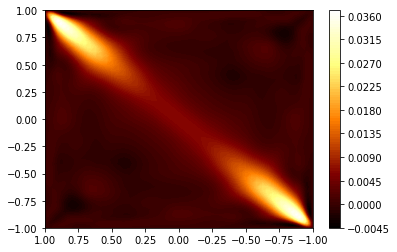

In [17]:
N = 62; a0 = 0.25; b0 = 2./3.
#covMat = statInst.covMat
covMat = cov_vel_tmp
q = np.sqrt(pseudo.clencurt(N))
Qinv = np.diag( 1./np.concatenate((q,q,q)))
covMat = Qinv @ covMat @ Qinv
covMat = 4.* covMat/a0/b0
#z = miscUtil.nodesCellCenters(nCells=192)
z = pseudo.chebdif(N,1)[0]
plt.contourf(z, z,np.real(covMat[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('afmhot'))
#plt.xscale("log")#; plt.yscale("log")
#plt.clim([0., 1.0e-4])
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()
#print(np.diag(covMat[:N,:N]))

In [ ]:
uff0 = miscUtil.bin2arr(specDataDir+'uFF_it45000.dat')
uffRealSum = uff0.copy().real
uffAbsSum = np.abs(uff0.copy())
for t in range(45500,75500,500):
    uff = miscUtil.bin2arr(specDataDir+'uFF_it%d.dat'%t)
    uffRealSum += uff.real
    uffAbsSum += np.abs(uff)
uffRealSum = uffRealSum/301.
uffAbsSum  = uffAbsSum/301.
z = pseudo.chebdif(386,1)[0][1:-1]
#plt.plot(z, uffRealSum, z, uffAbsSum)
#plt.show()

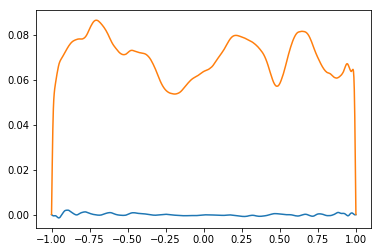

In [32]:
plt.plot(z, uffRealSum[2,0], z, uffAbsSum[2,0])
plt.show()

# Covariance matrices from DNS

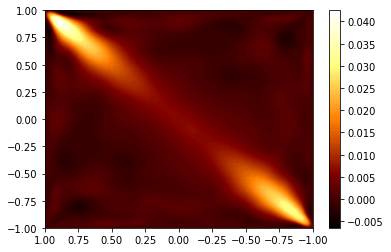

In [23]:
N = 62; a0 = 0.25; b0 = 2./3.
covDataDir = os.environ['DATA186']+'cov/'
covMat =np.load(covDataDir+'covR186N192l10m10.npy')
q = np.sqrt(2.*pseudo.clencurt(N))
Qinv = np.diag( 1./np.concatenate((q,q,q)))
covMat = Qinv @ covMat @ Qinv
covMat = 4.* covMat/a0/b0
#z = miscUtil.nodesCellCenters(nCells=192)
z = pseudo.chebdif(N,1)[0]
plt.contourf(z, z,np.real(covMat[0*N:1*N,0*N:1*N]),100,cmap=plt.get_cmap('afmhot'))
#plt.xscale("log")#; plt.yscale("log")
#plt.clim([0., 1.0e-4])
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.show()
#print(np.diag(covMat[:N,:N]))

# Premultiplied energy spectrum

In [ ]:
a = 0.25; b=2./3.
lArr = np.arange(1., 32.)
mArr = np.arange(24.)
N = 192
energyArr = np.zeros((lArr.size+1, N))
premulEnergyArr = energyArr.copy()
for l in lArr:
    kx = l*a
    for m in mArr:
        covMat = np.load(covDataDir + 'covR186N192l%02dm%02d.npy'%(l,m))
        energyArr[int(l)] += np.diag(np.abs(covMat[:N,:N]))
    
    premulEnergyArr[int(l)] = kx*energyArr[int(l)]
    

    
    
#z = pseudo.chebdif(N+2,0)[0][1:-1]
plt.contourf(lArr[1:], z, premulEnergyArr.T)
plt.colorbar()
plt.show()
    
    
    

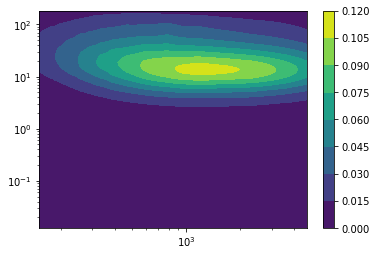

In [29]:
z = miscUtil.nodesCellCenters(nCells=192)
plt.contourf(186.*2.*np.pi/a/lArr, 186.*(1.-z[:96]), premulEnergyArr[1:,:96].T)
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
plt.show()


In [23]:
lArr.shape, z.shape, premulEnergyArr.T.shape

((31,), (192,), (192, 32))

In [ ]:
print(premulEnergyArr[1:].T.shape,lArr[1:].shape, z.shape)
phi11 = premulEnergyArr[1:, :-33:-1]
plt.contourf(590.*2.*np.pi/lArr, 590.*(1.-z[:32]), phi11.T)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('$\lambda_x^+$',fontsize=15); plt.ylabel('$z^+$',fontsize=15)
plt.title('$\phi_{11}$ at bottom wall',fontsize=15)
plt.colorbar()
plt.show()

(64, 64) (63,) (384,)


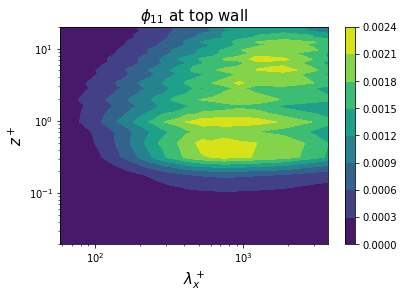

In [54]:
print(premulEnergyArr[1:].T.shape,lArr[1:].shape, z.shape)
phi11 = premulEnergyArr[1:, :32]
plt.contourf(590.*2.*np.pi/lArr, 590.*(1.-z[:32]), phi11.T)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('$\lambda_x^+$',fontsize=15); plt.ylabel('$z^+$',fontsize=15)
plt.title('$\phi_{11}$ at top wall',fontsize=15)
plt.colorbar()
plt.show()

In [4]:
a = 0.04
svals = 0.001 * np.arange(1.,50.)

In [23]:
svals = np.abs(svals)
svalsNew = svals.copy()
svalsNew[svals<=a] = 0.
svalsNew[svals>a] = svals[svals>a] - a


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [5]:
svalsNew = (  ( 1. - a/np.abs(svals) ) * svals)  * (np.abs(svals) > a).astype(int)
svalsNew = np.abs(svalsNew)


In [8]:
svalsNew

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.001,  0.002,  0.003,  0.004,  0.005,  0.006,  0.007,  0.008,
        0.009])

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
a, b, Re: 0.5 1.0 2000.0
Eigenvalue solution returned with error norm: 3.70352287928e-11
(162,) (162, 162) (81,)


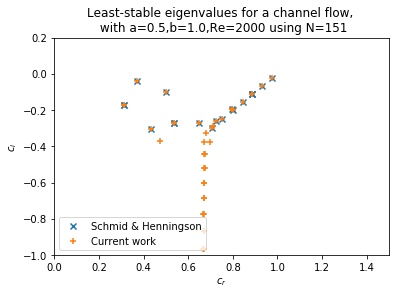

In [18]:
%run validate_LSA_channel.py

# Component-wise energy amplification
Jovanovic & Bamieh (2005) JFM

In [89]:
from scipy.linalg import solve_sylvester
N=100
aArr = 10**np.linspace(-4., 0.5, 50)
bArr = 10**np.linspace(-2., 1.2, 90)
H2normArr = np.zeros((aArr.size, bArr.size))
H2normArrTest = np.zeros((aArr.size, bArr.size))

for ind0 in range(aArr.size):
    a = aArr[ind0]
    for ind1 in range(bArr.size):
        b = bArr[ind1]
        k2 = a**2 + b**2
        I = np.identity(N); Z = np.zeros((N,N), dtype=np.complex)
        covMat = np.identity(3*N)
        statInst = ops.statComp(Re=2000., a=a, b=b, N=N, covMat = covMat)
        statInst.U = 1. - statInst.y**2
        statInst.dU = -2.*statInst.y
        statInst.d2U = -2.*np.ones(N)
        Umat = np.diag(statInst.U)
        dUmat = np.diag(statInst.dU)
        d2Umat = np.diag(statInst.d2U)
        Re = statInst.Re
        
        A, C, B = statInst.makeSystem()
        Badj = C.copy()
        Cadj = B.copy()
        
        # Building Aadj:
        Aadj = np.zeros((2*N, 2*N), dtype=np.complex)
        Delta = statInst.D2 - k2 * I
        DeltaInv = np.linalg.solve(Delta, I)
        Aadj11 = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + \
                1./Re*DeltaInv @ (Delta @ Delta)
        Aadj22 = 1.j*a*Umat + 1./Re*Delta
        Aadj21 = -1.j*b*DeltaInv @ dUmat
        
        Aadj = np.vstack(( 
                np.hstack(( Aadj11, Aadj21 )),
                np.hstack((  Z    , Aadj22 ))   ))
        
        # Solve Sylvester equation, AX + XB = Q, arguments to the function are A,B,Q
        # In present formulation, the equation is AX + X A* = - B B*
        X = solve_sylvester(A, Aadj, - B @ Badj)
                
        
        H2normArr[ind0,ind1] = np.sqrt(np.trace( X @ Cadj @ C))
        #H2normArrTest[ind0,ind1] = np.trace( )
        

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.01 2000.0


/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:45: ComplexWarning: Casting complex values to real discards the imaginary part


Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.0108631319854 2000.0
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.0118007636532 2000.0
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Usi

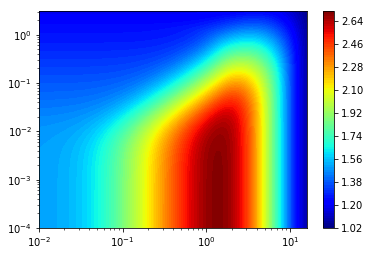

In [92]:
plt.contourf(bArr, aArr, np.log10(H2normArr),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.colorbar()
plt.savefig('figures/'+'gainLaminar.pdf',format='pdf')
plt.show()

In [80]:
from scipy.linalg import solve_sylvester
a = 1.; b= 1.; N = 50; k2 = a**2 + b**2
I = np.identity(N); Z = np.zeros((N,N), dtype=np.complex)

covMat = np.identity(3*N)
statInst = ops.statComp(Re=2000., a=a, b=b, N=N, covMat=covMat)
statInst.U = 1. - statInst.y**2
statInst.dU = -2.*statInst.y
statInst.d2U = -2.*np.ones(N)
Umat = np.diag(statInst.U)
dUmat = np.diag(statInst.dU)
d2Umat = np.diag(statInst.d2U)
Re = statInst.Re


A, C, B = statInst.makeSystem()
Badj = C.copy()
Cadj = B.copy()

# Building Aadj:
Aadj = np.zeros((2*N, 2*N), dtype=np.complex)
Delta = statInst.D2 - k2 * I
DeltaInv = np.linalg.solve(Delta, I)
Aadj11 = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + \
        1./Re*DeltaInv @ (Delta @ Delta)
Aadj22 = 1.j*a*Umat + 1./Re*Delta
Aadj21 = -1.j*b*DeltaInv @ dUmat

Aadj = np.vstack(( 
        np.hstack(( Aadj11, Aadj21 )),
        np.hstack((  Z    , Aadj22 ))   ))

X = solve_sylvester(A, Aadj, - B @ Badj)

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1.0 1.0 2000.0


11631.488748991533

AttributeError: module 'numpy' has no attribute 'ismatrix'